https://en.wikipedia.org/wiki/Price%27s_model
https://stackabuse.com/courses/graphs-in-python-theory-and-implementation/lessons/representing-graphs-in-code/
https://webwebpage.github.io/
https://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Networks/Preferential%20Attachment.nlogo
https://pypi.org/project/pyportfolioopt/

That was fun, but now we need a way to represent direction!

Authors have a single paper. CURRENTLY price's model only uses the degree of a paper. Not it's in degrees, which tells us how many people cited this paper. To game the system I only have to reference a lot of papers and I am now more likely to get cited.

In [1]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px


def init_web(authors):
    # columns of the dataframe we init later
    cols = ['citing_author','paper_citing_id','cited_author' ,'paper_cited_id', 'time' ]
    # hold the data we create later
    data = []
    # for all of the authors that is passed into the dataframe, have them cite another outher
    for citing_author in authors:
        # have a random citation between authors
        cited_author = random.choice(authors)
        # no author should cite themselves on the first step
        while cited_author == citing_author:
            cited_author = random.choice(authors)
        # append the citations into the data with the paper indexes and time step
        data.append([citing_author,authors.index(citing_author),cited_author , authors.index(cited_author), 0])
        # create and return a dataframe of the data
    return pd.DataFrame(data, columns = cols)

def get_in_degrees(df):
    # probability function of a new edge connecting to any node with a degree k is
    in_degrees =  df[['cited_author', 'paper_cited_id']].value_counts()
    
     # include the authors who didn't get cited       
    for row in df[['citing_author', 'paper_citing_id']].values.tolist():
        author_paper = tuple(row)
        if  author_paper not in in_degrees.index:
            zero_citations = pd.Series({author_paper:0})
            in_degrees = pd.concat([in_degrees,zero_citations])
    return in_degrees
    

def get_p_k(df, k_0 = 1):
    # probability function of a new edge connecting to any node with a degree k is
    in_degrees =  df[['cited_author', 'paper_cited_id']].value_counts()
    
     # include the authors who didn't get cited       
    for row in df[['citing_author', 'paper_citing_id']].values.tolist():
        author_paper = tuple(row)
        if  author_paper not in in_degrees.index:
            zero_citations = pd.Series({author_paper:0})
            in_degrees = pd.concat([in_degrees,zero_citations])

    # count the degrees that are present in our dataset
    degree_counts = in_degrees.value_counts()
    
    # using Price's model for publishing calculate the probability that a new author will cite a paper of a certain degree
    p_k = degree_counts / degree_counts.sum()
    
    return p_k

def get_citation(df, k_0 = 1):
    p_k = get_p_k(df,k_0 = 1)
    # probability function of a new edge connecting to any node with a degree k is
    in_degrees =  df[['cited_author', 'paper_cited_id']].value_counts()
    
     # include the authors who didn't get cited       
    for row in df[['citing_author', 'paper_citing_id']].values.tolist():
        author_paper = tuple(row)
        if  author_paper not in in_degrees.index:
            zero_citations = pd.Series({author_paper:0})
            in_degrees = pd.concat([in_degrees,zero_citations])

    # count the degrees that are present in our dataset
    degree_counts = in_degrees.value_counts()
    
    # using Price's model for publishing calculate the probability that a new author will cite a paper of a certain degree
    p_k = degree_counts / degree_counts.sum()
    k_probs = ((p_k.index + k_0) * p_k) / sum((p_k.index + k_0) * p_k)
    
    # chose a random degree with the weight from the Price Model
    random_degree = random.choices(k_probs.index, weights=k_probs, k=1)[0]

    # from the chose degree, find an author with that many citations. Sometimes there are several, so we randomly 
    # select from that subset
    chosen = in_degrees[in_degrees == random_degree]
    
    # randomly chose and other that has the specified degree
    num_chosen = chosen.shape[0]
    if num_chosen == 1:
        newly_cite = chosen.index.values[0]
    else:
        newly_cite = random.choice(chosen.index.values)
        
    return newly_cite

def step(df,authors, cols = ['citing_author','paper_citing_id','cited_author' ,'paper_cited_id', 'time' ]):
    next_step = []
    current_paper_ix = df['time'].max()
    for i,auth in enumerate(authors): 
        cited = get_citation(df)
        citing_id = df['paper_citing_id'].max()  + i + 1
        next_step.append([auth,citing_id, cited[0], cited[1], current_paper_ix + 1])
    next_step = pd.DataFrame(next_step, columns = cols)
    return pd.concat([df,next_step], axis = 0, ignore_index = True)

def step_multiple_cite(df,authors, max_cite = 1, cols = ['citing_author','paper_citing_id','cited_author' ,'paper_cited_id', 'time' ]):
    # max_cite must be less than the current papers that exist!
    next_step = []
    current_paper_ix = df['time'].max()
    # for each author figure out who they should cite
    for i,auth in enumerate(authors): 
        
        citing_id = df['paper_citing_id'].max()  + i + 1
        # for a random number of citations limited by the max number of cites, pull a random citation and create the meta data
        # range starts at 0, and doesn't include the stop number
        for cite_num in range(1,random.randint(1,max_cite) + 1):
            # pull a citation according to price's model
            cited = get_citation(df)
            while [auth,citing_id, cited[0], cited[1], current_paper_ix + 1] in next_step:
                cited = get_citation(df)
                
            next_step.append([auth,citing_id, cited[0], cited[1], current_paper_ix + 1])
    next_step = pd.DataFrame(next_step, columns = cols)
    return pd.concat([df,next_step], axis = 0, ignore_index = True)

def take_steps(df,authors, num_of_steps):
    for i in range(num_of_steps):
        #df = step_multiple_cite(df, authors, max_cite)
        df = step(df, authors)
    return df

def take_steps_multiple_cite(df,authors, num_of_steps, max_cite = 1):
    if max_cite > len(authors) - 1:
        print('max_cite cannot be larger than the number of papers, which is the case if max_cite > len(authors) - 1 at the start')
    for i in range(num_of_steps):
        df = step_multiple_cite(df, authors, max_cite)
        #df = step(df, authors)
    return df

def get_return(df):
    return df['cited_author'].value_counts() / df['cited_author'].value_counts().sum()

def plot_cumsum(unique_items, var = 'cited_author', legend = True):
    for item in unique_items:
    #plt.plot(sim_mcite[sim_mcite['cited_author'] == scientist]['time'].value_counts(sort = False))
        plt.plot(sim_mcite[sim_mcite[var] == item]['time'].value_counts(sort = False).cumsum())
    if legend:
        plt.legend(unique_items)
    plt.title('%s: Cumulative Sum of Citations'%var);
    plt.xlabel('Time', fontsize=12);
    plt.ylabel('Citations', fontsize=12);
    plt.show()

def plot_citations(unique_items, var = 'cited_author', legend = True):
    for item in unique_items:
        plt.plot(sim_mcite[sim_mcite[var] == item]['time'].value_counts(sort = False))
        #plt.plot(sim_mcite[sim_mcite['cited_author'] == scientist]['time'].value_counts(sort = False).cumsum())
    if legend:
        plt.legend(unique_items)
    plt.title('%s: Citations Over Time'%var);
    plt.xlabel('Time', fontsize=12);
    plt.ylabel('Citations', fontsize=12);
    plt.show()


#def trial(authors, num_trials)

In [ ]:
authors = ['Einstein','Curie','Newton','Lovelace','Darwin','Bill Nye']
authors = [i for i in range(120)]
papers = init_web(authors) 
#get_citation(papers) 
#sim = take_steps(papers,authors, 10)
sim_mcite = take_steps_multiple_cite(papers,authors, 60, max_cite = 10)
sim_mcite.to_csv('120_authors_60_steps_10_max_cite.csv')
#sim

In [ ]:
sim_mcite

In [55]:
sim_mcite.to_csv('20_authors_60_steps_3_max_cite.csv')

In [11]:
sim_mcite['cited_author'].value_counts()

cited_author
Lovelace    192
Darwin      130
Bill Nye    128
Newton      117
Einstein    108
Curie        55
Name: count, dtype: int64

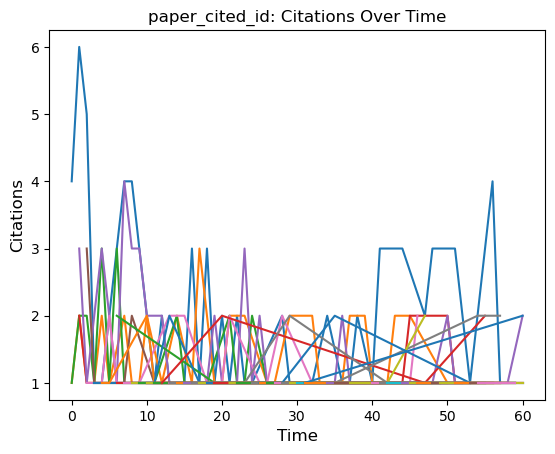

In [53]:
#published_papers = 

sim_mcite['paper_citing_id'].unique()
plot_citations(sim_mcite['paper_cited_id'].unique(), var = 'paper_cited_id', legend = False)



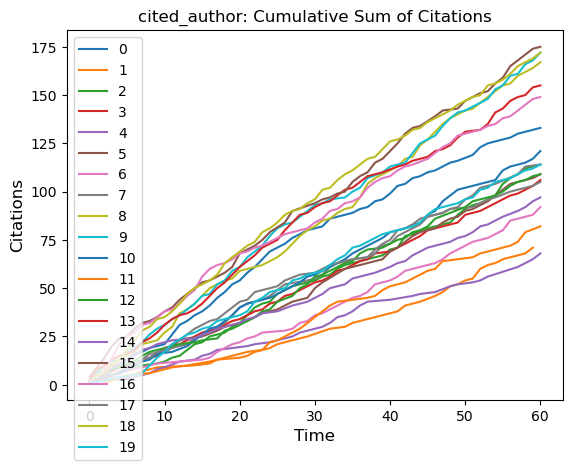

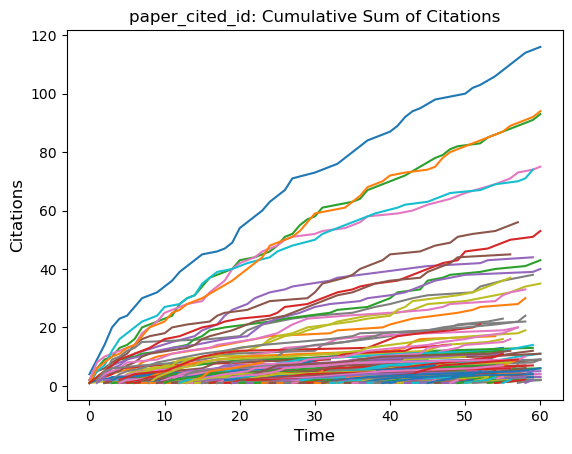

In [56]:

#sim_mcite[['cited_author','time']].groupby('time')
#plot_citations(authors)
plot_cumsum(authors)
plot_cumsum(sim_mcite['paper_cited_id'].unique(), var = 'paper_cited_id', legend = False)

In [28]:
sci = 'Einstein'

cumulative = sim[sim['citing_author'] == sci]['time'].value_counts().cumsum()
# sim[['citing_author', 'time']].value_counts() #['time'].value_counts()



citing_author  time
Bill Nye       0       1
Lovelace       5       1
Einstein       2       1
               3       1
               4       1
                      ..
Darwin         5       1
               6       1
               7       1
               8       1
Newton         10      1
Name: count, Length: 66, dtype: int64

In [193]:
print(sim[sim['cited_author'] == 'Newton'])
get_return(sim[sim['time'] == 3])

   citing_author  paper_citing_id cited_author  paper_cited_id  time
8         Newton                8       Newton               2     1
20        Newton               20       Newton               2     3
36      Einstein               36       Newton              26     6
47      Bill Nye               47       Newton               2     7
52        Darwin               52       Newton               2     8
54      Einstein               54       Newton              14     9
60      Einstein               60       Newton              32    10
65      Bill Nye               65       Newton              26    10


cited_author
Einstein    0.333333
Lovelace    0.333333
Newton      0.166667
Curie       0.166667
Name: count, dtype: float64

In [100]:
authors = ['Einstein','Curie','Newton','Lovelace','Darwin','Bill Nye']

papers = init_web(authors) 
#get_citation(papers) 
sim = take_steps(papers,authors, 10)
sim

,citing_author,paper_citing_id,cited_author,paper_cited_id,time
0,Einstein,0,Lovelace,3,0
1,Curie,1,Darwin,4,0
2,Newton,2,Lovelace,3,0
3,Lovelace,3,Curie,1,0
4,Darwin,4,Lovelace,3,0
...,...,...,...,...,...
61,Curie,61,Einstein,0,10
62,Newton,62,Bill Nye,5,10
63,Lovelace,63,Darwin,4,10
64,Darwin,64,Curie,55,10


In [140]:
sim[sim['time'] == 1]

,citing_author,paper_citing_id,cited_author,paper_cited_id,time
6,Einstein,6,Einstein,0,1
7,Curie,7,Einstein,0,1
8,Newton,8,Lovelace,3,1
9,Lovelace,9,Lovelace,3,1
10,Darwin,10,Lovelace,3,1
11,Bill Nye,11,Einstein,0,1


In [199]:
returns = pd.Series(0,authors)
concat_me = [returns]
for time in sim['time'].unique():
    concat_me.append(get_return(sim[sim['time'] == time]))
returns_over_time = pd.concat(concat_me,axis =1).fillna(0).T.reset_index(drop = True).reset_index(names = 'year')
returns_over_time

,year,Einstein,Curie,Newton,Lovelace,Darwin,Bill Nye
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.500000,0.166667,0.000000,0.000000,0.166667,0.166667
2,2,0.333333,0.333333,0.166667,0.000000,0.166667,0.000000
3,3,0.666667,0.000000,0.000000,0.166667,0.000000,0.166667
4,4,0.333333,0.166667,0.166667,0.333333,0.000000,0.000000
5,5,0.333333,0.166667,0.000000,0.500000,0.000000,0.000000
6,6,0.500000,0.166667,0.000000,0.166667,0.000000,0.166667
7,7,0.500000,0.000000,0.166667,0.166667,0.000000,0.166667
8,8,0.166667,0.166667,0.166667,0.333333,0.166667,0.000000
9,9,0.166667,0.166667,0.166667,0.500000,0.000000,0.000000


In [197]:
returns = pd.Series(0,authors)
concat_me = [returns]
for time in sim['time'].unique():
    concat_me.append(get_log_return(sim[sim['time'] == time]))
    
returns_over_time = pd.concat(concat_me,axis =1).fillna(0).T.reset_index(drop = True).reset_index(names = 'year')
returns_over_time 
# retruns should be difference 

,year,Einstein,Curie,Newton,Lovelace,Darwin,Bill Nye
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,-0.693147,-1.791759,0.000000,0.000000,-1.791759,-1.791759
2,2,-1.098612,-1.098612,-1.791759,0.000000,-1.791759,0.000000
3,3,-0.405465,0.000000,0.000000,-1.791759,0.000000,-1.791759
4,4,-1.098612,-1.791759,-1.791759,-1.098612,0.000000,0.000000
5,5,-1.098612,-1.791759,0.000000,-0.693147,0.000000,0.000000
6,6,-0.693147,-1.791759,0.000000,-1.791759,0.000000,-1.791759
7,7,-0.693147,0.000000,-1.791759,-1.791759,0.000000,-1.791759
8,8,-1.791759,-1.791759,-1.791759,-1.098612,-1.791759,0.000000
9,9,-1.791759,-1.791759,-1.791759,-0.693147,0.000000,0.000000


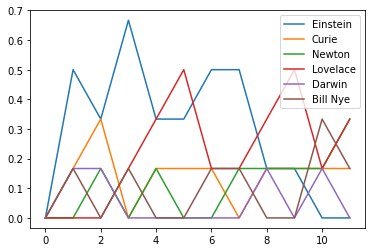

In [213]:
#fig = px.line(returns_over_time, x = 'year', y = 'Newton')
#fig.show()
for scientist in returns_over_time.columns[1:]:
    plt.plot(returns_over_time[scientist])
plt.legend(authors)

In [202]:
for scientist in returns_over_time.columns[1:]:
    fig = px.line(returns_over_time, x="year", y=scientist)
    fig.show()


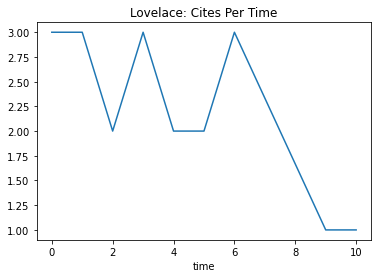

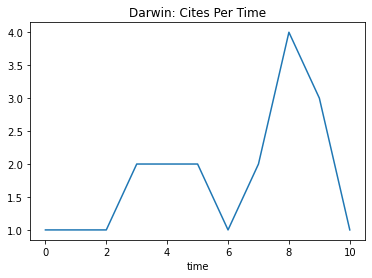

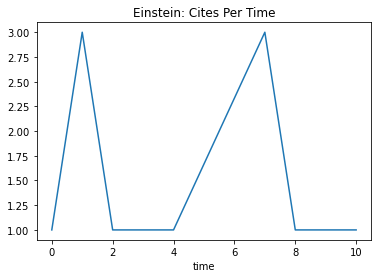

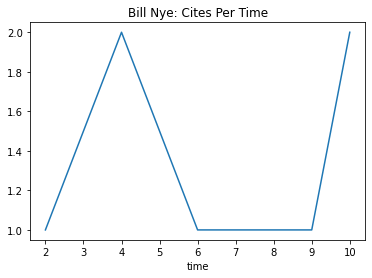

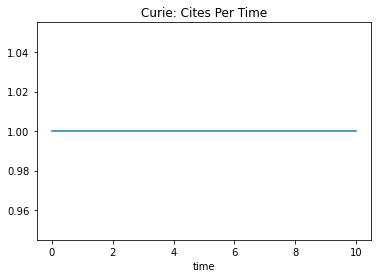

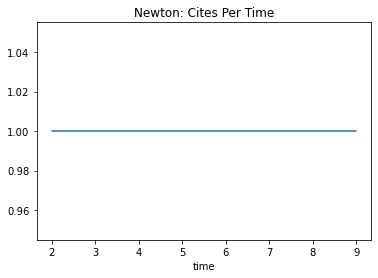

In [135]:
for cited in sim['cited_author'].value_counts().index:
    cites_per_time = sim[sim['cited_author'] == cited]['time'].value_counts() #.groupby('time')
    cites_per_time = cites_per_time.sort_index()
    cites_graph = cites_per_time.plot(title = '%s: Cites Per Time'%cited)
    #cites_graph.title('%s: Cites Per Time'%top_cited)
    plt.show()
#plt.plot( cites_per_time.values)

In [87]:
# I feel confident that multiple cite is working as it should
sim_mc = take_steps_multiple_cite(papers, authors, 10, 5)
np.log(sim_mc['cited_author'].value_counts()) / np.log(sim_mc['cited_author'].value_counts().sum())

cited_author
Newton      0.819635
Curie       0.629899
Bill Nye    0.524440
Einstein    0.384146
Darwin      0.330885
Lovelace    0.262220
Name: count, dtype: float64

In [79]:
#sim['cited_author'].value_counts()

sim[['citing_author','paper_citing_id']].value_counts() #.nunique()
#sim[sim['citing_author'] == 'Bill Nye']

citing_author  paper_citing_id
Bill Nye       5                  1
Lovelace       33                 1
Einstein       12                 1
               18                 1
               24                 1
                                 ..
Darwin         34                 1
               40                 1
               46                 1
               52                 1
Newton         62                 1
Name: count, Length: 66, dtype: int64

In [65]:
sim = take_steps(papers, authors, 10)
get_log_return(sim)

cited_author
Newton      0.702788
Darwin      0.689883
Curie       0.612210
Lovelace    0.572337
Einstein    0.262220
Bill Nye    0.165443
Name: count, dtype: float64

In [63]:
# probability function of a new edge connecting to any node with a degree k is
in_degrees =  sim_mc[['cited_author', 'paper_cited_id']].value_counts()

 # include the authors who didn't get cited       
for row in sim[['citing_author', 'paper_citing_id']].values.tolist():
    author_paper = tuple(row)
    if  author_paper not in in_degrees.index:
        zero_citations = pd.Series({author_paper:0})
        in_degrees = pd.concat([in_degrees,zero_citations])

# count the degrees that are present in our dataset
degree_counts = in_degrees.value_counts()

# using Price's model for publishing calculate the probability that a new author will cite a paper of a certain degree
p_k = degree_counts / degree_counts.sum()
print(in_degrees)
print()
print(degree_counts)
p_k

Curie     1     14
Newton    2     10
Darwin    4      9
          10     5
Lovelace  3      3
                ..
Curie     61     0
Newton    62     0
Lovelace  63     0
Darwin    64     0
Bill Nye  65     0
Length: 66, dtype: int64

0     43
1     12
2      5
3      2
14     1
10     1
9      1
5      1
Name: count, dtype: int64


0     0.651515
1     0.181818
2     0.075758
3     0.030303
14    0.015152
10    0.015152
9     0.015152
5     0.015152
Name: count, dtype: float64

In [233]:
#(sim['cited_author'].value_counts()) / sim['citing_author'].value_counts()
sim[['cited_author', 'paper_cited_id']].value_counts()

cited_author  paper_cited_id
Lovelace      3                 19
Curie         1                 10
Newton        2                  7
Curie         13                 6
Darwin        4                  6
              16                 2
Einstein      0                  2
Darwin        34                 2
              10                 2
Curie         43                 2
Bill Nye      23                 1
Einstein      6                  1
              12                 1
              24                 1
              48                 1
Bill Nye      35                 1
Lovelace      27                 1
Bill Nye      17                 1
Name: count, dtype: int64

In [214]:
step(papers)

,citing_author,paper_citing_id,cited_author,paper_cited_id,time
0,Einstein,0,Bill Nye,5,0
1,Curie,1,Bill Nye,5,0
2,Newton,2,Bill Nye,5,0
3,Lovelace,3,Newton,2,0
4,Darwin,4,Curie,1,0
5,Bill Nye,5,Newton,2,0
6,Einstein,6,Newton,2,1
7,Curie,7,Newton,2,1
8,Newton,8,Newton,2,1
9,Lovelace,9,Lovelace,3,1


In [210]:
for i,auth in enumerate(authors): 
    print(i + 1)

1
2
3
4
5
6


In [208]:
#['time'].max()

5

In [181]:
df = papers
# probability function of a new edge connecting to any node with a degree k is
in_degrees =  df[['cited_author', 'paper_cited_id']].value_counts()

in_degrees

cited_author  paper_cited_id
Curie         1                 2
Darwin        4                 2
Lovelace      3                 1
Newton        2                 1
Name: count, dtype: int64

In [182]:
for row in df[['citing_author', 'paper_citing_id']].values.tolist():
    author_paper = tuple(row)
    if  author_paper not in in_degrees.index:
        zero_citations = pd.Series({author_paper:0})
        print(zero_citations)
        in_degrees = pd.concat([in_degrees,zero_citations])
in_degrees

Einstein  0    0
dtype: int64
Bill Nye  5    0
dtype: int64


Curie     1    2
Darwin    4    2
Lovelace  3    1
Newton    2    1
Einstein  0    0
Bill Nye  5    0
dtype: int64

In [186]:
# count the degrees that are present in our dataset
degree_counts = in_degrees.value_counts()
k_0 = 1
# using Price's model for publishing calculate the probability that a new author will cite a paper of a certain degree
p_k = degree_counts / degree_counts.sum()
k_probs = ((p_k.index + k_0) * p_k) / sum((p_k.index + k_0) * p_k)

In [188]:
# chose a random degree with the weight from the Price Model
random_degree = random.choices(k_probs.index, weights=k_probs, k=1)[0]

In [190]:
# from the chose degree, find an author with that many citations. Sometimes there are several, so we randomly 
    # select from that subset
chosen = in_degrees[in_degrees == random_degree]

In [192]:
num_chosen = chosen.shape[0]
if num_chosen == 1:
    newly_cite = chosen.index.values[0]
else:
    newly_cite = random.choice(chosen.index.values)

In [198]:
list(random.choice(chosen.index.values))

['Curie', 1]

In [135]:
['Einstein','Curie','Newton','Lovelace','Darwin','Bill Nye']

1

In [134]:
sim['paper_cited'].value_counts()
sim['cited_author'].value_counts()

cited_author
Bill Nye     92
Einstein     85
Curie        54
Lovelace     28
Darwin       22
Newton       15
Curie1        7
Einstein1     1
Darwin1       1
Lovelace1     1
Name: count, dtype: int64

In [126]:
sim

,cites,paper_cited,cited_author
0,Einstein0,Lovelace0,Lovelace
1,Curie0,Lovelace0,Lovelace
2,Newton0,Curie0,Curie
3,Lovelace0,Darwin0,Darwin
4,Darwin0,Lovelace0,Lovelace
...,...,...,...
301,Curie10,Darwin5,Darwin
302,Newton10,Lovelace5,Lovelace
303,Lovelace10,Curie3,Curie
304,Darwin10,Curie9,Curie


In [119]:
get_citation(papers)


'Bill Nye0'

In [116]:
import networkx as nx



In [115]:
author_network = papers[['cites','paper_cited']].values.tolist()
web = Web(adjacency = author_network)

# color by name so that we can group a scientist's papers together
#web.display.colorBy = 'name'

# we'll compute node size by the `age` metadata attribute
#web.display.sizeBy = 'p_km'

# how "long" are the edges
#web.display.linkLength = 50

web.show()

author_network

[['Einstein0', 'Lovelace0'],
 ['Curie0', 'Lovelace0'],
 ['Newton0', 'Einstein0'],
 ['Lovelace0', 'Darwin0'],
 ['Darwin0', 'Newton0'],
 ['Bill Nye0', 'Curie0']]

# NetworkX

In [ ]:


G = nx.Graph()
G.add_edge("A", "B", weight=4)
G.add_edge("B", "D", weight=2)
G.add_edge("A", "C", weight=3)
G.add_edge("C", "D", weight=4)

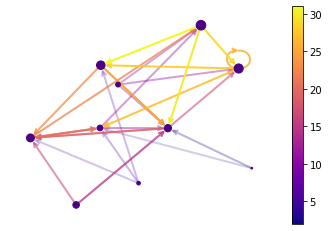

In [117]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 13648  # Seed random number generators for reproducibility
G = nx.random_k_out_graph(10, 3, 0.5, seed=seed)
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [89]:

print(current_paper_ix)
print()
for i in range(current_paper_ix + 1, current_paper_ix + 3):
    print(i)
    df_new = step(df,step_num = i)
df_new

0

1
2


,cites,paper_cited,cited_author
0,Einstein0,Lovelace0,Lovelace
1,Curie0,Darwin0,Darwin
2,Newton0,Darwin0,Darwin
3,Lovelace0,Bill Nye0,Bill Nye
4,Darwin0,Einstein0,Einstein
5,Bill Nye0,Bill Nye0,Bill Nye
6,Einstein2,Curie0,Curie
7,Curie2,Lovelace0,Lovelace
8,Newton2,Einstein0,Einstein
9,Lovelace2,Darwin0,Darwin


In [88]:
for i in range(2,3):
    print(i)

2


In [ ]:
df_new = step(df)
for i in range(2,8):
    df_new = step(df_new,step_num = i)
df_new

In [302]:
df['paper_cited'].value_counts()

paper_cited
Bill Nye0    3
Newton0      2
Einstein0    1
Name: count, dtype: int64

Curie0     0
Newton0    0
dtype: int64

Darwin0      2
Bill Nye0    2
dtype: int64

Lovelace0    1
Einstein0    1
dtype: int64

Darwin0      2
Bill Nye0    2
dtype: int64

Darwin0      2
Bill Nye0    2
dtype: int64

Darwin0      2
Bill Nye0    2
dtype: int64

Bill Nye0    3
dtype: int64

Einstein0    1
Curie0       1
dtype: int64

Darwin0    5
dtype: int64

Newton0      0
Einstein1    0
Curie1       0
Newton1      0
Lovelace1    0
Darwin1      0
Bill Nye1    0
dtype: int64

Einstein0    1
Curie0       1
dtype: int64

Bill Nye0    3
dtype: int64

Newton0      0
Einstein1    0
Curie1       0
Lovelace1    0
Darwin1      0
Bill Nye1    0
Einstein2    0
Curie2       0
Newton2      0
Lovelace2    0
Darwin2      0
Bill Nye2    0
dtype: int64

Lovelace0    2
Einstein0    2
Curie0       2
dtype: int64

Newton0      0
Einstein1    0
Curie1       0
Lovelace1    0
Darwin1      0
Bill Nye1    0
Einstein2    0
Curie2       0
Newton2      0
Lovelace2    0
Darwin2      0
Bill Nye2    0
dtype: int64

B

,cites,paper_cited,cited_author
0,Einstein0,Lovelace0,Lovelace
1,Curie0,Darwin0,Darwin
2,Newton0,Darwin0,Darwin
3,Lovelace0,Bill Nye0,Bill Nye
4,Darwin0,Einstein0,Einstein
5,Bill Nye0,Bill Nye0,Bill Nye
6,Einstein1,Curie0,Curie
7,Curie1,Darwin0,Darwin
8,Newton1,Lovelace0,Lovelace
9,Lovelace1,Bill Nye0,Bill Nye


In [288]:
in_degrees
#in_degrees

Bill Nye0    3
Newton0      2
Einstein0    1
Curie0       0
Lovelace0    0
Darwin0      0
dtype: int64

In [276]:
authors = ['Einstein','Curie','Newton','Lovelace','Darwin','Bill Nye']
df = init_web(authors)
print(df)
get_citation(df)

       cites paper_cited cited_author
0  Einstein0   Einstein0     Einstein
1     Curie0     Newton0       Newton
2    Newton0   Bill Nye0     Bill Nye
3  Lovelace0   Bill Nye0     Bill Nye
4    Darwin0   Bill Nye0     Bill Nye
5  Bill Nye0     Newton0       Newton


array(['Newton0'], dtype=object)

In [277]:
get_citation(df)

array(['Bill Nye0'], dtype=object)

In [279]:


# count how many nodes are going in and out
in_degrees = df['paper_cited'].value_counts()

# fraction of nodes with degree k
p_k = in_degrees / in_degrees.sum()
p_k
# probability function of a new edge connecting to any node with a degree k is
find_prob = lambda k: ((k + k_0) * p_k[p_k.index == k].values) / sum(((p_k.index + k_0) * p_k.values))
find_prob(p_k)
k_probs = pd.Series(find_prob(p_k.index).values, p_k.index)

# chose a random degree with the weight from the Price Model
#random_degree = random.choices(k_probs.index, weights=k_probs, k=1)[0]

#random_degree

ValueError: operands could not be broadcast together with shapes (3,) (0,) 

In [ ]:
degree_counts= df['paper_cited'].value_counts().value_counts()
p_k = degree_counts / degree_counts.sum()
k_probs = ((p_k.index + 1) * p_k) / sum((p_k.index + 1) * p_k)
#random_degree = 
random.choices(k_probs.index, weights=k_probs, k=1)[0]

In [ ]:
# we need to be able to represent our direction of the nodes
authors = ['Einstein','Curie','Newton','Lovelace','Darwin','Bill Nye']
cols = ['cites', 'paper_cited', 'cited_author']
directed = pd.DataFrame(data = [['Einstein0','Curie0', 'Curie'],
                                ['Einstein0','Newton0', 'Newton'],
                                ['Einstein0','Lovelace0', 'Lovelace'],
                                ['Newton0','Lovelace0', 'Lovelace'],
                                ['Lovelace0','Bill Nye0', 'Bill Nye'],
                                ['Bill Nye0','Einstein0', 'Einstein'],
                               ['Darwin0','Lovelace0', 'Lovelace']],
                        columns = cols)

directed

In [ ]:
get_citation(directed)
#directed.loc[len(directed)] = [author + str(int(title[-1]) + 1),get_citation(directed),author]

In [ ]:
directed

In [ ]:
next_step

In [ ]:
directed

In [ ]:

# fix title versus author
def get_citation(df, k_0 = 1):
    
    # count how many nodes are going in and out
    in_degrees = df['paper_cited'].value_counts()
    out_degrees = df['cites'].value_counts()
    
    # merge in and out frames
    degrees = pd.merge(in_degrees,out_degrees,how = 'outer', left_index = True,right_index = True)
    degrees.rename(columns = {'count_x':'in_degrees', 'count_y':'out_degrees'}, inplace = True)
    
    # how many degrees does each author have?
    degrees['k'] = degrees.sum(axis =1)
    
    # fraction of nodes with degree k
    p_k = degrees['k'].value_counts() / degrees['k'].value_counts().sum()
    
    # mean out degree
    m = sum((p_k.index * p_k.values))
    
    # probability function of a new edge connecting to any node with a degree k is
    find_prob = lambda k: ((k + k_0) * p_k[p_k.index == k].values) / sum(((p_k.index + k_0) * p_k.values))
    k_probs = pd.Series(find_prob(p_k.index).values, p_k.index)

    # chose a random degree with the weight from the Price Model
    random_degree = random.choices(k_probs.index, weights=k_probs, k=1)[0]

    # from the chose degree, find an author with that many citations. Sometimes there are several, so we randomly 
    # select from that subset
    chosen = degrees[degrees['k'] == random_degree]
    #print(chosen)
    num_chosen = chosen.shape[0]
    if num_chosen == 1:
        newly_cite = chosen.index
    else:
        newly_cite = random.choice(chosen.index)

    return newly_cite

In [ ]:
#get_citation(directed, title_or_author = 'title')
#chosen = degrees[degrees['k'] == random_degree]
#chosen


# count how many nodes are going in and out
in_degrees = directed['title'].value_counts()
out_degrees = directed['cites'].value_counts()

# merge in and out frames
degrees = pd.merge(in_degrees,out_degrees,how = 'outer', left_index = True,right_index = True)

degrees

In [ ]:
degrees[degrees['k'] == random_degree].index

In [ ]:
k_probs
print(rand_val)
rand_val = random.uniform(0, 1)
print(k_probs)
print(k_probs < rand_val)

In [ ]:
pd.Series(k_probs,p_k.index)

In [ ]:

find_prob(p_k.index).values



In [ ]:
#sum(((p_k.index + k_0) * p_k.values))
#p_k.index + k_0
#p_k.values
p_k['k'] == 4

In [ ]:
sum((p_k.index + k_0) * p_k.values)

In [ ]:
degrees

In [ ]:
p = {}

In [ ]:
directed['node1'].unique()


In [ ]:
authors = ['Einstein','Curie','Newton','Lovelace','Darwin','Bill Nye']
nodes = ['node1', 'node2']

directed = pd.DataFrame(data =[['Einstein','Curie','Newton','Darwin','Darwin','Bill Nye'],
                    ['Newton','Einstein','Darwin','Einstein','Einstein','Bill Nye']],
            columns = nodes)